c:\Users\matej\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\matej\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


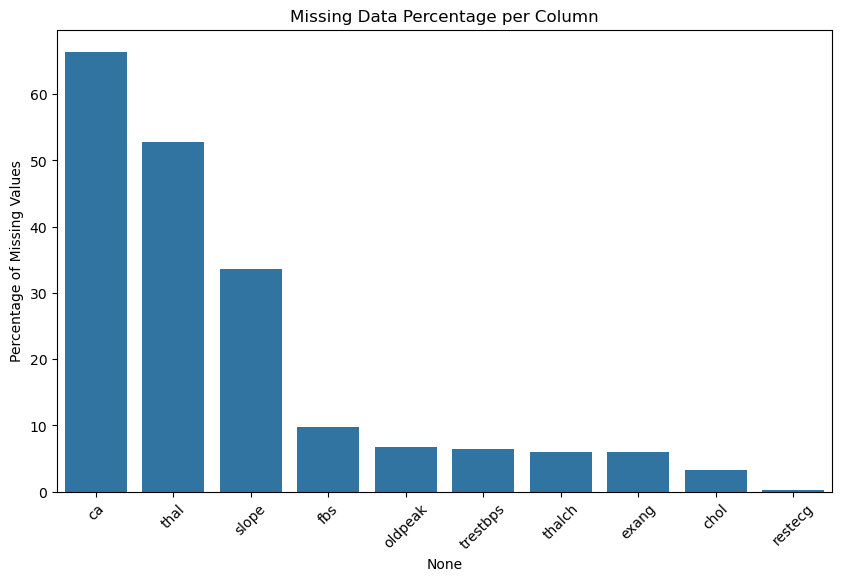

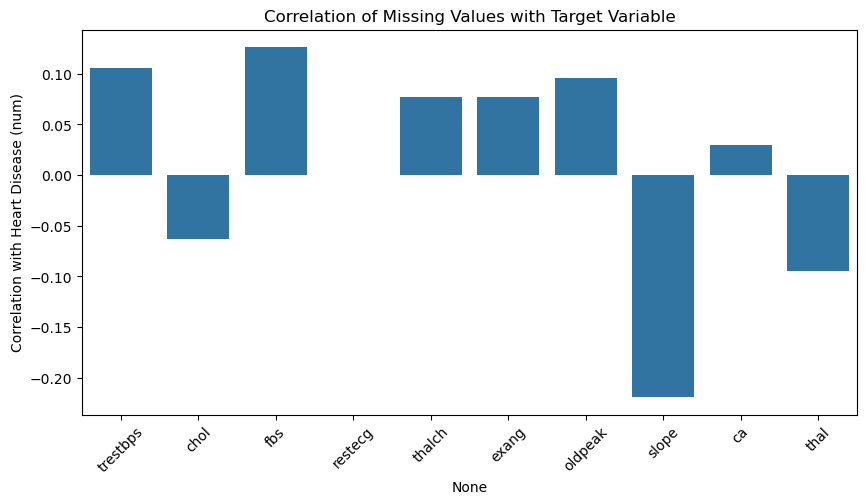

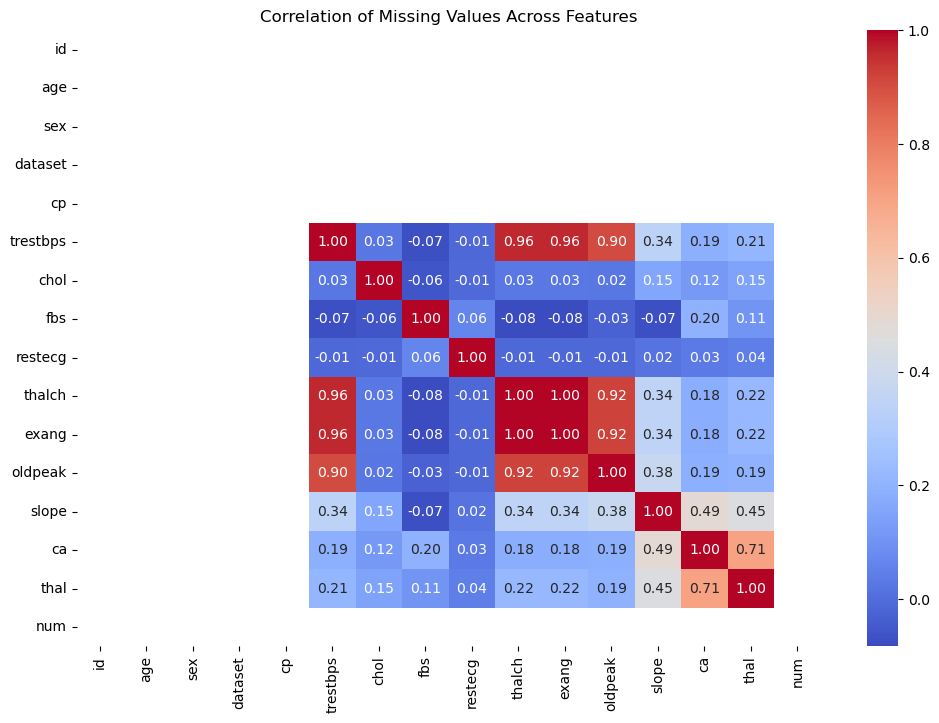

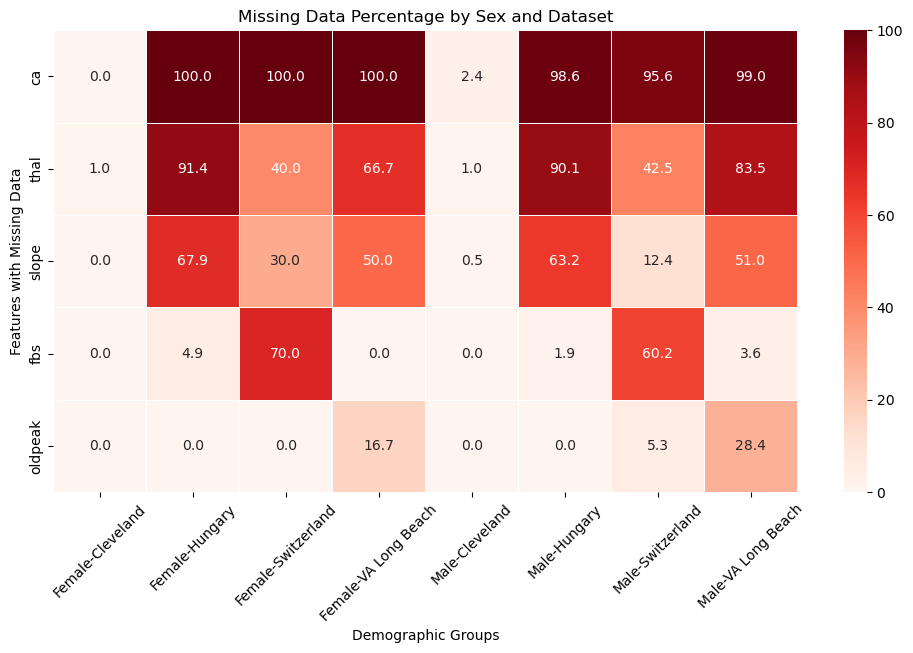

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("C:\\Users\\matej\\Downloads\\archive (6)\\heart_disease_uci.csv")

# Compute missing value statistics
missing_counts = df.isnull().sum()
missing_percent = (missing_counts / len(df)) * 100

# Create a missing data summary DataFrame
missing_df = pd.DataFrame({"Missing Count": missing_counts, "Missing Percent": missing_percent})
missing_df = missing_df[missing_df["Missing Count"] > 0].sort_values(by="Missing Percent", ascending=False)

# Compute correlation of missing values with target variable
missing_corr = df.isnull().astype(int).corrwith(df["num"]).dropna()

# Compute correlation matrix of missing values
missing_corr_matrix = df.isnull().astype(int).corr()

# Compute missing values by demographic groups (sex, dataset)
missing_by_group = df.groupby(["sex", "dataset"])[["ca", "thal", "slope", "fbs", "oldpeak"]].apply(lambda x: x.isnull().mean()) * 100

# Plot Missing Data Percentage per Column
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_df.index, y=missing_df["Missing Percent"])
plt.xticks(rotation=45)
plt.ylabel("Percentage of Missing Values")
plt.title("Missing Data Percentage per Column")
plt.show()

# Plot Correlation of Missing Values with Target Variable
plt.figure(figsize=(10, 5))
sns.barplot(x=missing_corr.index, y=missing_corr.values)
plt.xticks(rotation=45)
plt.ylabel("Correlation with Heart Disease (num)")
plt.title("Correlation of Missing Values with Target Variable")
plt.show()

# Plot Correlation of Missing Values Across Features (Heatmap)
plt.figure(figsize=(12, 8))
sns.heatmap(missing_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation of Missing Values Across Features")
plt.show()

# Plot Missing Values by Demographics (Heatmap)
plt.figure(figsize=(12, 6))
sns.heatmap(missing_by_group.T, cmap="Reds", annot=True, fmt=".1f", linewidths=0.5)
plt.title("Missing Data Percentage by Sex and Dataset")
plt.xlabel("Demographic Groups")
plt.ylabel("Features with Missing Data")
plt.xticks(rotation=45)
plt.show()


In [50]:
# Investigate missing values by demographic groups (age, sex, dataset)
missing_by_group = df.groupby(["sex", "dataset"])[["ca", "thal", "slope", "fbs", "oldpeak"]].apply(lambda x: x.isnull().mean()) * 100

# Check missing values correlation with target variable (heart disease presence)
missing_corr_target = df.isnull().astype(int).corrwith(df["num"]).dropna()

# Check correlation between missing values across features
missing_corr_matrix = df.isnull().astype(int).corr()

# Display missing data by demographic groups
print("### Missing Data by Demographics (Percentage of Missing Values) ###")
print(missing_by_group)

# Display missing data correlation with the target variable
print("\n### Correlation of Missing Data with Target Variable (Heart Disease) ###")
print(missing_corr_target)

# Display missing values correlation matrix
print("\n### Missing Values Correlation Matrix ###")
print(missing_corr_matrix)

### Missing Data by Demographics (Percentage of Missing Values) ###
                              ca       thal      slope        fbs    oldpeak
sex    dataset                                                              
Female Cleveland        0.000000   1.030928   0.000000   0.000000   0.000000
       Hungary        100.000000  91.358025  67.901235   4.938272   0.000000
       Switzerland    100.000000  40.000000  30.000000  70.000000   0.000000
       VA Long Beach  100.000000  66.666667  50.000000   0.000000  16.666667
Male   Cleveland        2.415459   0.966184   0.483092   0.000000   0.000000
       Hungary         98.584906  90.094340  63.207547   1.886792   0.000000
       Switzerland     95.575221  42.477876  12.389381  60.176991   5.309735
       VA Long Beach   98.969072  83.505155  51.030928   3.608247  28.350515

### Correlation of Missing Data with Target Variable (Heart Disease) ###
trestbps    0.105889
chol       -0.063604
fbs         0.126196
restecg     0.000178
thal

c:\Users\matej\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\matej\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


The analysis of missing data reveals several key insights. Firstly, missing values are highly concentrated in specific features (ca, thal, and slope), with missing percentages exceeding 50% in many cases, particularly among patients from Hungary, Switzerland, and VA Long Beach datasets. This suggests that some medical tests (e.g., for ca and thal) were either not conducted or not recorded for certain groups, possibly due to differences in clinical protocols or patient demographics. The correlation of missing values with the target variable (num, indicating heart disease presence) shows that missing values in slope are negatively correlated with heart disease, while missing values in trestbps, fbs, and oldpeak have a slight positive correlation. This could indicate a bias in data collection, where missing values are more common in healthier patients or those at lower risk. Additionally, the missing value correlation matrix highlights strong relationships between missingness in ca, thal, and slope, meaning that if one of these features is missing, the others are likely to be missing as well. This pattern suggests systematic data collection gaps rather than purely random missingness, which should be addressed through careful imputation or exclusion strategies in predictive modeling.

In [51]:
pip install catboost

In [52]:
#CatBoost model

#### PREPROCESSING ####
# Handle missing values
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()  # Include boolean columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Drop ID column if it exists
if 'id' in df.columns:
    df.drop(columns=['id'], inplace=True, errors='ignore')

# Fill missing values
df[categorical_cols] = df[categorical_cols].fillna("Unknown")
for col in numerical_cols:
    if col in df.columns:  
        df[col] = df[col].fillna(df[col].median())

# Convert boolean values to strings before encoding
df[categorical_cols] = df[categorical_cols].astype(str)

In [53]:
# Encode categorical features
cat_features = categorical_cols

# Define target and features
X = df.drop(columns=["num"])  # Features
y = df["num"]  # Target variable

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train CatBoostClassifier
catboost_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    cat_features=cat_features,
    verbose=100,
    random_seed=42
)

catboost_model.fit(X_train, y_train)

# Make predictions
y_pred = catboost_model.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)

0:	learn: 1.5710239	total: 45.7ms	remaining: 22.8s
100:	learn: 0.8118753	total: 4.97s	remaining: 19.6s
200:	learn: 0.6604465	total: 9.38s	remaining: 14s
300:	learn: 0.5488431	total: 13.8s	remaining: 9.12s
400:	learn: 0.4590351	total: 18.3s	remaining: 4.51s
499:	learn: 0.3881184	total: 22.7s	remaining: 0us
Accuracy: 0.6250
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.89      0.85        82
           1       0.58      0.60      0.59        53
           2       0.23      0.23      0.23        22
           3       0.29      0.24      0.26        21
           4       0.00      0.00      0.00         6

    accuracy                           0.62       184
   macro avg       0.38      0.39      0.39       184
weighted avg       0.59      0.62      0.61       184



c:\Users\matej\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\matej\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\matej\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The CatBoost model achieved an accuracy of 62.5%, indicating moderate performance in predicting heart disease severity. The classification report reveals significant class imbalance, with the majority class (0) achieving a high F1-score of 0.85, while minority classes (2, 3, and 4) performed poorly, with class 4 receiving an F1-score of 0.00, meaning it was never correctly predicted. The macro-averaged recall (0.39) and precision (0.38) suggest the model struggles to generalize across all classes, while the weighted average F1-score (0.61) is slightly better due to the dominance of class 0. The low recall for several classes indicates frequent misclassification, particularly for more severe heart disease cases. To improve performance, data balancing techniques (e.g., oversampling, undersampling), feature engineering, hyperparameter tuning, or alternative models (such as XGBoost or LightGBM) should be explored.

Next, I will try to change the target variable from 5 classes to 3.

In [54]:
# Modify the target variable (combine classes 1 & 2, and 3 & 4)
df["num"] = df["num"].replace({1: 1, 2: 1, 3: 2, 4: 2})  # 0 remains unchanged

# Encode categorical variables using Label Encoding
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])  # Convert categorical to numeric
    label_encoders[col] = le  # Store encoders for potential inverse transformation

# Define features and target
X = df.drop(columns=["num"])  # Features
y = df["num"]  # Target variable
cat_features = [X.columns.get_loc(col) for col in categorical_cols]  # Indices for categorical features

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train CatBoostClassifier
catboost_model = CatBoostClassifier(
    iterations=500,        # Number of boosting iterations
    learning_rate=0.05,    # Step size
    depth=6,               # Depth of trees
    cat_features=cat_features,  # Categorical feature handling
    verbose=100,           # Print updates every 100 iterations
    random_seed=42
)

# Train the model
catboost_model.fit(X_train, y_train)

# Make predictions
y_pred = catboost_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)

0:	learn: 1.0715195	total: 33.7ms	remaining: 16.8s
100:	learn: 0.5799329	total: 2.84s	remaining: 11.2s
200:	learn: 0.4728820	total: 5.77s	remaining: 8.58s
300:	learn: 0.3986572	total: 8.74s	remaining: 5.78s
400:	learn: 0.3491289	total: 11.9s	remaining: 2.95s
499:	learn: 0.3012875	total: 14.8s	remaining: 0us
Accuracy: 0.6685
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.83      0.79        82
           1       0.62      0.65      0.64        75
           2       0.40      0.22      0.29        27

    accuracy                           0.67       184
   macro avg       0.59      0.57      0.57       184
weighted avg       0.65      0.67      0.65       184



The modified CatBoost model, trained on three consolidated heart disease classes instead of five, achieved an accuracy of 66.85%, reflecting an improvement over the previous model. The classification report shows that the model performs best for Class 0 (No heart disease), with an F1-score of 0.79 and recall of 0.83, indicating that most healthy patients are correctly identified. Class 1 (Mild/Moderate heart disease) also performs reasonably well, with an F1-score of 0.64 and recall of 0.65. However, Class 2 (Severe heart disease) remains the weakest category, with a low recall of 0.22, meaning 78% of severe cases are misclassified, often as milder heart disease or no disease at all. The macro-average F1-score of 0.57 indicates moderate overall performance, but class imbalance remains an issue. To enhance the model’s ability to detect severe heart disease, applying SMOTE to oversample Class 2, hyperparameter tuning, or class-weighted training in CatBoost could significantly improve recall and overall classification accuracy.

Apply SMOTE to the model to balance the 3-class dataset, ensuring severe heart disease cases (Class 2) are better represented.

In [55]:
from imblearn.over_sampling import SMOTE
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Define CatBoost model
catboost_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    cat_features=[X.columns.get_loc(col) for col in categorical_cols],  # Categorical feature handling
    verbose=100,
    random_seed=42
)

# Train the model
catboost_model.fit(X_train, y_train)

# Make predictions
y_pred = catboost_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)

0:	learn: 1.0765664	total: 42.1ms	remaining: 21s
100:	learn: 0.5690644	total: 3.07s	remaining: 12.1s
200:	learn: 0.4486070	total: 6.09s	remaining: 9.06s
300:	learn: 0.3709435	total: 9.14s	remaining: 6.04s
400:	learn: 0.3148037	total: 12.3s	remaining: 3.04s
499:	learn: 0.2734280	total: 15.2s	remaining: 0us
Accuracy: 0.7287
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.82      0.79        82
           1       0.61      0.59      0.60        82
           2       0.80      0.78      0.79        83

    accuracy                           0.73       247
   macro avg       0.73      0.73      0.73       247
weighted avg       0.73      0.73      0.73       247



After applying SMOTE to balance the dataset for the 3-class target model, the CatBoost model achieved an accuracy of 72.87%, reflecting a noticeable improvement over the previous 66.85% without SMOTE. The classification report shows a much more balanced performance across all three classes, with Class 2 (Severe Heart Disease) improving significantly—achieving an F1-score of 0.79 compared to 0.29 before SMOTE. This suggests that oversampling helped the model better distinguish severe cases, reducing the bias toward majority classes. Class 0 (No heart disease) still performs best, with an F1-score of 0.79 and recall of 0.82, while Class 1 (Mild/Moderate Heart Disease) remains the weakest category, with an F1-score of 0.60 and recall of 0.59, indicating some continued misclassification. However, the macro and weighted F1-scores of 0.73 suggest that the model is now treating all classes more equally, unlike the previous imbalance favoring Class 0. These results confirm that SMOTE was effective in improving severe case classification, though further refinements—such as hyperparameter tuning or feature selection—could help enhance performance even further.

Try to reduce the number of classes from 3 to 2 (join 2 and 3).

In [56]:
# Modify the target variable (combine classes 1 & 2)
df["num"] = df["num"].replace({2: 1})  # 0 remains unchanged

# Encode categorical variables using Label Encoding
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])  # Convert categorical to numeric
    label_encoders[col] = le  # Store encoders for potential inverse transformation

# Define features and target
X = df.drop(columns=["num"])  # Features
y = df["num"]  # Target variable
cat_features = [X.columns.get_loc(col) for col in categorical_cols]  # Indices for categorical features

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train CatBoostClassifier
catboost_model = CatBoostClassifier(
    iterations=500,        # Number of boosting iterations
    learning_rate=0.05,    # Step size
    depth=6,               # Depth of trees
    cat_features=cat_features,  # Categorical feature handling
    verbose=100,           # Print updates every 100 iterations
    random_seed=42
)

# Train the model
catboost_model.fit(X_train, y_train)

# Make predictions
y_pred = catboost_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)

0:	learn: 0.6661367	total: 23.6ms	remaining: 11.8s
100:	learn: 0.2896628	total: 2.16s	remaining: 8.52s
200:	learn: 0.2325472	total: 4.26s	remaining: 6.34s
300:	learn: 0.1799805	total: 6.56s	remaining: 4.34s
400:	learn: 0.1401674	total: 9.04s	remaining: 2.23s
499:	learn: 0.1095938	total: 11.5s	remaining: 0us
Accuracy: 0.8478
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.79      0.82        82
           1       0.84      0.89      0.87       102

    accuracy                           0.85       184
   macro avg       0.85      0.84      0.84       184
weighted avg       0.85      0.85      0.85       184



Training the CatBoost model on a binary classification task (No heart disease vs. Heart disease) significantly improved performance, achieving an accuracy of 84.78%. The model demonstrates strong predictive ability for both classes, with Class 0 (No heart disease) achieving an F1-score of 0.82 and Class 1 (Heart disease) performing even better with an F1-score of 0.87 and recall of 0.89, meaning it correctly identifies 89% of heart disease cases. The macro-average and weighted-average F1-scores are both 0.84-0.85, indicating balanced performance across the two classes. This improvement over the previous multi-class models suggests that combining heart disease cases into a single category enhances classification accuracy, possibly due to a reduction in class overlap and better feature generalization. However, the slightly lower recall for Class 0 (0.79) suggests that some healthy individuals might still be misclassified. Further improvements could be achieved through feature selection, hyperparameter tuning, or alternative models like XGBoost or ensemble learning to refine the decision boundary.

Comparison of Model Performance Across Different Class Structures


The progression from a 5-class model to a 2-class model demonstrates a clear trade-off between classification accuracy and clinical relevance. The original 5-class model struggled significantly, achieving only 62.5% accuracy, with severe heart disease cases (Class 4) being almost completely misclassified (F1-score: 0.00). The model's inability to differentiate between different levels of heart disease highlights the challenge of working with imbalanced, fine-grained classifications in medical datasets. By merging similar classes into a 3-class model, the accuracy increased slightly to 66.85%, and while performance on Class 2 (severe heart disease) improved somewhat, it still had a very low recall (0.22), meaning a large proportion of severe cases were being misclassified as milder conditions.

The introduction of SMOTE in the 3-class model significantly improved overall performance, increasing accuracy to 72.87% and, more importantly, balancing recall across all three classes. The most notable improvement was in Class 2 (severe heart disease), where recall jumped from 0.22 to 0.78, meaning that far fewer severe cases were being misclassified. This suggests that oversampling successfully addressed the class imbalance issue, allowing the model to better recognize less frequent conditions. However, despite these improvements, the 3-class model still performed worse than the binary classification model in terms of overall accuracy. The 2-class model, which grouped all heart disease cases together, reached an impressive 84.78% accuracy, with a high F1-score of 0.87 for Class 1 (heart disease), demonstrating that the model could reliably distinguish between healthy and at-risk patients.

Limitations of Reducing the Number of Classes


While reducing the number of target classes improves classification accuracy, it comes at the cost of clinical usefulness. In a real-world medical setting, distinguishing between mild, moderate, and severe heart disease is crucial for determining appropriate treatments. A binary classification model (healthy vs. heart disease) is useful for initial screening, but it lacks the granularity needed for more advanced diagnosis and risk stratification. Similarly, while the 3-class model improves classification balance, it still merges some clinically distinct conditions, potentially reducing its applicability in cases where more precise diagnosis is needed.

Ultimately, the choice of classification granularity depends on the intended use case. If the goal is to improve overall diagnostic accuracy and reduce misclassification, a binary model is the most effective. However, if the focus is on providing doctors with more actionable insights, a 3-class model with SMOTE might be the best compromise. Future improvements could involve hybrid approaches, such as hierarchical classification, where a binary model first identifies heart disease cases, followed by a secondary model to classify disease severity—thus balancing accuracy and medical relevance.

In [57]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


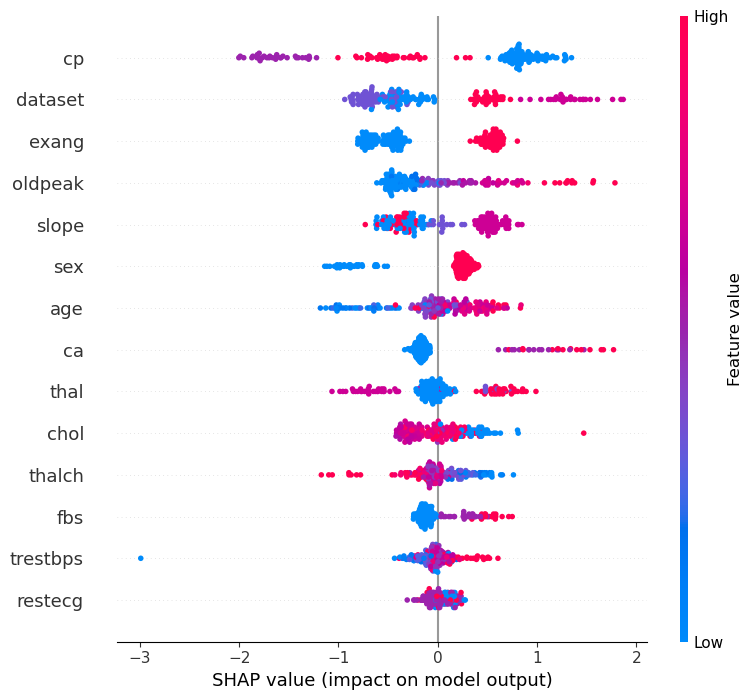

Feature Importance Ranking (SHAP):
     Feature  SHAP Importance
3         cp         0.923821
2    dataset         0.634186
9      exang         0.553082
10   oldpeak         0.423754
11     slope         0.409408
1        sex         0.380077
0        age         0.346872
12        ca         0.316156
13      thal         0.310729
5       chol         0.245219
8     thalch         0.215452
6        fbs         0.197913
4   trestbps         0.147032
7    restecg         0.101213


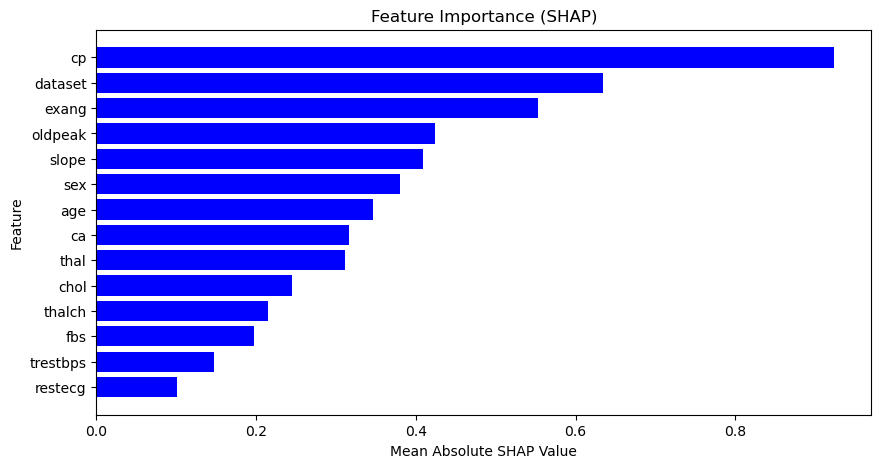

In [60]:
import shap
import numpy as np
# Get feature importance using SHAP (SHapley Additive exPlanations)
explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer.shap_values(X_test)

# Plot summary plot of feature importance
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

# Compute mean absolute SHAP values for each feature
feature_importance = np.abs(shap_values).mean(axis=0)
feature_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'SHAP Importance': feature_importance
}).sort_values(by='SHAP Importance', ascending=False)

# Display the feature importance dataframe
print("Feature Importance Ranking (SHAP):")
print(feature_importance_df)

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.barh(feature_importance_df['Feature'], feature_importance_df['SHAP Importance'], color='blue')
plt.xlabel("Mean Absolute SHAP Value")
plt.ylabel("Feature")
plt.title("Feature Importance (SHAP)")
plt.gca().invert_yaxis()
plt.show()

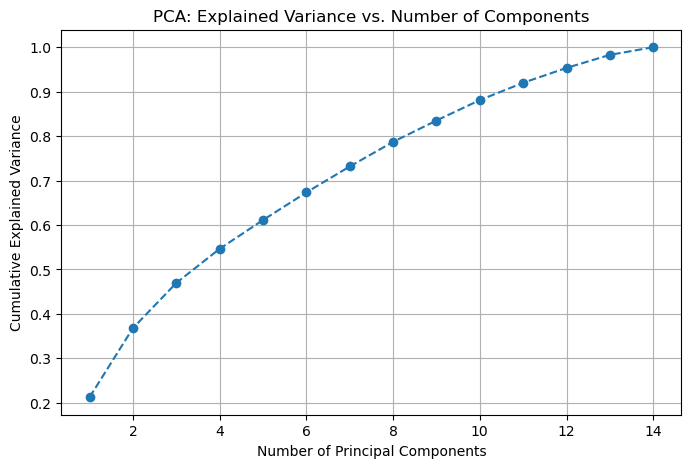

In [61]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Select only numerical features for PCA
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
X_numerical = df[numerical_cols].drop(columns=['num'], errors='ignore')  # Remove target variable

# Standardize the features before applying PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numerical)

# Apply PCA
pca = PCA(n_components=None)  # Keep all components initially
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot variance explained by each principal component
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Explained Variance vs. Number of Components')
plt.grid()
plt.show()


Feature evaluation through PCA (Principal Component Analysis) and SHAP (SHapley Additive Explanations) plays a crucial role in understanding the dataset and optimizing model performance. The PCA cumulative variance plot suggests that a subset of principal components can explain a significant portion of the variance, highlighting the potential to reduce dimensionality while maintaining predictive power. This is particularly useful for improving model efficiency without sacrificing too much information. Meanwhile, the SHAP summary plot and feature importance ranking provide deeper insights into how individual features impact the model’s predictions. For instance, 'cp' (chest pain type), 'exang' (exercise-induced angina), and 'oldpeak' (ST depression induced by exercise) are among the most influential variables, indicating their strong relationship with heart disease risk. These insights guide feature selection, allowing us to prioritize the most relevant attributes while potentially removing less important ones (e.g., 'restecg' and 'trestbps'). By combining PCA for dimensionality reduction and SHAP for interpretability, we achieve a balance between model performance, efficiency, and explainability, which is essential for making informed, data-driven medical predictions.